# Segmentation Task Results

In [1]:
from sklearn.metrics import precision_recall_fscore_support
from difflib import SequenceMatcher
from scripts.config import DefaultArgsNamespace
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve

from metrics.metrics import *

In [2]:
args = DefaultArgsNamespace()

results_csv = './results/model_id_65620366_on_20241101-204042/preds.csv'
# path to results csv
results_dir = results_csv.rsplit('/', 1)[0]

task = args.dataloader_params['task']
print("Task is", task)

generate_plots = False

Task is segmentation


# Preprocessing

In [3]:
# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc


In [4]:
# Read CSV
df = pd.read_csv(results_csv)

unique_actions = np.union1d(np.concatenate(df['keystep_id'].apply(eval).values), df['pred_keystep_id'].values)
print("Unique actions", unique_actions)

num_classes = len(args.dataloader_params['keysteps'])
# Lists to hold ground truth and predicted sequences for all trials
all_ground_truth = []
all_predicted = []

# Convert the lists in subject_id and trial_id columns to single values
df['subject_id'] = df['subject_id'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)
df['trial_id'] = df['trial_id'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)

# Show the updated dataframe
df.head()

# Convert string arrays to actual lists for all relevant columns
def convert_to_list(value):
    try:
        return eval(value) if isinstance(value, str) else value
    except:
        return value  # If eval fails, return the original value

# Apply the conversion to the columns that contain arrays as strings
columns_to_convert = ['keystep_label', 'keystep_id', 'start_frame', 'end_frame', 'start_t', 'end_t', 'all_preds']  # Add any other columns if needed

for column in columns_to_convert:
    df[column] = df[column].apply(convert_to_list)

# Show the first few rows to verify the conversion
df.head()

# Function to convert string arrays and extract the inner array
def extract_inner_array(value):
    try:
        # Convert the string to a Python list
        converted_value = eval(value) if isinstance(value, str) else value
        # If it's a list of lists, return the first list (the inner array)
        if isinstance(converted_value, list) and len(converted_value) > 0 and isinstance(converted_value[0], list):
            return converted_value[0]
        return converted_value
    except:
        return value  # If eval fails, return the original value

# Apply the conversion to the columns that contain arrays as strings
columns_to_convert = ['keystep_label', 'keystep_id', 'start_frame', 'end_frame', 'start_t', 'end_t', 'all_preds']  # Add any other columns if needed

for column in columns_to_convert:
    df[column] = df[column].apply(extract_inner_array)

# Show the first few rows to verify the conversion
df.head()


Unique actions [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 32 33 34]


,keystep_label,keystep_id,start_frame,end_frame,start_t,end_t,window_start_frame,window_end_frame,subject_id,trial_id,pred_keystep_id,all_preds
0,"[approach_patient, approach_patient, approach_...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.490999937057495, 2.490999937057495, 2.49099...",0,120,ms1,5,0,"[7.69677734375, 3.072441577911377, 0.388590216..."
1,"[check_responsiveness, check_responsiveness, c...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 7...","[140, 140, 140, 140, 140, 140, 140, 140, 140, ...","[2.490999937057495, 2.490999937057495, 2.49099...","[4.677000045776367, 4.677000045776367, 4.67700...",120,240,ms1,5,3,"[1.881857991218567, 3.8536157608032227, 4.9324..."
2,"[check_breathing, check_breathing, check_breat...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[171, 171, 171, 171, 171, 171, 171, 171, 171, ...","[275, 275, 275, 275, 275, 275, 275, 275, 275, ...","[5.714029788970947, 5.714029788970947, 5.71402...","[9.191969871520996, 9.191969871520996, 9.19196...",240,360,ms1,5,4,"[1.4064195156097412, 2.6366944313049316, 3.989..."
3,"[request_assistance, request_assistance, reque...","[6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[314, 314, 362, 362, 362, 362, 362, 362, 362, ...","[362, 362, 518, 518, 518, 518, 518, 518, 518, ...","[10.481419563293457, 10.481419563293457, 12.10...","[12.100000381469727, 12.100000381469727, 17.29...",360,480,ms1,5,15,"[-0.5058533549308777, -0.24373848736286163, -1..."
4,"[request_aed, request_aed, request_aed, reques...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[362, 362, 362, 362, 362, 362, 362, 362, 362, ...","[518, 518, 518, 518, 518, 518, 518, 518, 518, ...","[12.100000381469727, 12.100000381469727, 12.10...","[17.293920516967773, 17.293920516967773, 17.29...",480,600,ms1,5,15,"[-1.1145381927490234, -0.782731831073761, -1.5..."


# Generate metrics

In [5]:
# Grouping by subject_id and trial_id
results = []

# Assuming 'results_csv' is defined earlier and points to the path of the results CSV
results_dir = results_csv.rsplit('/', 1)[0]

# IoU thresholds
IoU_thresholds = [0.1, 0.25, 0.5]

all_accuracy = []
all_edit_distances = []
all_edit_scores = []
all_precisions = {threshold: [] for threshold in IoU_thresholds}
all_recalls = {threshold: [] for threshold in IoU_thresholds}
all_f1_k = {threshold: [] for threshold in IoU_thresholds}

for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    print("*" * 50)
    print(f"Subject: {subject}, Trial: {trial}")
    
    # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()  # Ground truth per frame
    predicted = group['pred_keystep_id'].tolist()  # Predicted per frame
    
    def repeat_elements(arr, Y):
        # Use list comprehension to repeat each element Y times
        return [[element] * Y for element in arr]

    Y = len(ground_truth[0])  # For example, repeat each element 3 times
    new_array = repeat_elements(predicted, Y)
    predicted = new_array

    edit_distances_for_trial = []
    edit_scores_for_trial = []

    # Calculate edit distance and edit score for each window and average
    for gt, pred in zip(ground_truth, predicted):
        edit_distance = calculate_edit_distance(ground_truth=gt, predicted=pred)
        edit_score = calculate_edit_score(gt, pred, edit_distance)

        edit_distances_for_trial.append(edit_distance)
        edit_scores_for_trial.append(edit_score)

    # Calculate average edit distance and edit score for the trial
    edit_distance = int(np.mean(edit_distances_for_trial))
    edit_score = np.mean(edit_scores_for_trial)

    all_edit_distances.append(edit_distance)
    all_edit_scores.append(edit_score)

    print("edit_distance: ", edit_distance)
    print("edit_score: ", edit_score)

    # Flatten ground truth and predicted sublists
    ground_truth = [item for sublist in ground_truth for item in sublist]
    predicted = [item for sublist in predicted for item in sublist]

    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    f1_aggregated_metrics = {}

    for threshold in IoU_thresholds:
        f1_score, precision, recall, TP, FP, FN = calculate_f1_at_k(ground_truth, predicted, threshold, n_classes=num_classes)
        # Store precision, recall, f1 metrics for each threshold
        metrics = {
            f'precision@{threshold}': precision,
            f'recall@{threshold}': recall,
            f'f1@{threshold}': f1_score,
        }
        # Append precision, recall, and f1 to the respective lists
        all_precisions[threshold].append(precision)
        all_recalls[threshold].append(recall)
        all_f1_k[threshold].append(f1_score)

        # Merge metrics into a single dictionary for appending to results
        f1_aggregated_metrics.update(metrics)


    ## Calculate accuracy
    accuracy = np.mean(np.array(ground_truth) == np.array(predicted))
    print("accuracy: ", accuracy)
    
    all_accuracy.append(accuracy)

    # Append ground truth and predicted to global lists
    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    # Append result for this subject and trial
    results.append({
        'subject_id': subject,
        'trial_id': trial,
        'accuracy': accuracy,
        **f1_aggregated_metrics,  # Unpack the aggregated f1 metrics
        'ground_truth': ground_truth,
        'predicted': predicted,
        'edit_score': edit_score,
        'edit_distance': edit_distance

    })




**************************************************
Subject: ms1, Trial: 0
edit_distance:  42
edit_score:  0.6478260869565217
n_pred:  8
n_true:  14
i 0
pred_labels[i] 0
i 1
pred_labels[i] 2
i 2
pred_labels[i] 3
i 3
pred_labels[i] 4
i 4
pred_labels[i] 15
i 5
pred_labels[i] 8
i 6
pred_labels[i] 15
i 7
pred_labels[i] 14
n_pred:  8
n_true:  14
i 0
pred_labels[i] 0
i 1
pred_labels[i] 2
i 2
pred_labels[i] 3
i 3
pred_labels[i] 4
i 4
pred_labels[i] 15
i 5
pred_labels[i] 8
i 6
pred_labels[i] 15
i 7
pred_labels[i] 14
n_pred:  8
n_true:  14
i 0
pred_labels[i] 0
i 1
pred_labels[i] 2
i 2
pred_labels[i] 3
i 3
pred_labels[i] 4
i 4
pred_labels[i] 15
i 5
pred_labels[i] 8
i 6
pred_labels[i] 15
i 7
pred_labels[i] 14
accuracy:  0.6478260869565218
**************************************************
Subject: ms1, Trial: 1
edit_distance:  72
edit_score:  0.39677741935483873
n_pred:  14
n_true:  22
i 0
pred_labels[i] 0
i 1
pred_labels[i] 3
i 2
pred_labels[i] 15
i 3
pred_labels[i] 8
i 4
pred_labels[i] 0
i 5
pre

/sfs/weka/scratch/anonymous/compute/2024/repos/EgoExoEMS/Benchmarks/ActionRecognition/MTRSAP/metrics/metrics.py:117: RuntimeWarning: invalid value encountered in double_scalars
  F1 = 2 * (precision*recall) / (precision+recall)


### Save results to csvs

In [6]:
# Save the results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'{results_dir}/subject_wise_results.csv', index=False)

# Calculate average metrics
average_accuracy = np.mean(all_accuracy)
average_edit_distance = int(np.mean(all_edit_distances))
average_edit_score = np.mean(all_edit_scores)

# Calculate the average precision, recall, and f1 for each IoU threshold
average_precisions = {f'average_precision@{threshold}': np.mean(all_precisions[threshold]) for threshold in IoU_thresholds}
average_recalls = {f'average_recall@{threshold}': np.mean(all_recalls[threshold]) for threshold in IoU_thresholds}
average_f1_k = {f'average_f1@{threshold}': np.mean(all_f1_k[threshold]) for threshold in IoU_thresholds}

# Prepare the dictionary for average metrics
average_metrics = {
    'accuracy': average_accuracy,
    'edit_distance': average_edit_distance,
    'edit_score': average_edit_score,
}
average_metrics.update(average_precisions)
average_metrics.update(average_recalls)
average_metrics.update(average_f1_k)


# Convert the average metrics dictionary to a DataFrame and save it as CSV
average_metrics_df = pd.DataFrame(average_metrics, index=[0])
average_metrics_df.to_csv(f'{results_dir}/average_metrics.csv', index=False)

# Calculate final class-wise accuracy across all trials
final_classwise_accuracy = calculate_final_classwise_accuracy(all_ground_truth, all_predicted, unique_actions)
print("Final Class-wise Accuracy:")
for action, accuracy in final_classwise_accuracy.items():
    print(f"{action}: {accuracy}")

# Save the final class-wise accuracy to CSV
classwise_accuracy_df = pd.DataFrame.from_dict(final_classwise_accuracy, orient='index', columns=['accuracy'])
classwise_accuracy_csv_path = f'{results_dir}/final_classwise_accuracy.csv'
classwise_accuracy_df.to_csv(classwise_accuracy_csv_path, index_label='action')

Final Class-wise Accuracy:
0: 0.6717
1: 0.1882
2: 0.526
3: 0.43
4: 0.7486
5: 0.0
6: 0.0
7: 0.1929
8: 0.5769
9: 0.4042
10: 0.2281
11: 0.2166
12: 0.0
13: 0.3622
14: 0.5899
15: 0.4547
16: 0.6969
17: 0.2919
19: 0.4674
20: 0.0
21: 0.0975
22: 0.0
23: 0.2627
24: 0.0
25: 0.0
26: 0.0
27: 0.0
28: 0.0734
29: 0.0
30: 0.0
32: 0.0
33: 0.5314
34: 0.0


# Plotting

In [7]:
# if not generate_plots:
#     print("Plots not generated")
#     exit()

### Helper functions

In [8]:
# Function to update start_frame and end_frame based on contiguous segments
def update_start_end_frames(df, column_name):
    start_frames = []
    end_frames = []
    
    # Iterate through the dataframe to find segments
    start = 0
    current_id = df[column_name][0]
    
    for i in range(1, len(df)):
        if df[column_name][i] != current_id:
            # End of a segment, record start and end
            start_frames.append(start)
            end_frames.append(i - 1)
            
            # Reset start and current_id for the new segment
            start = i
            current_id = df[column_name][i]
    
    # Capture the last segment
    start_frames.append(start)
    end_frames.append(len(df) - 1)
    
    # Assign the start and end frames to new columns
    df['start_frame'] = 0
    df['end_frame'] = 0
    for start, end in zip(start_frames, end_frames):
        df.loc[start:end, 'start_frame'] = start
        df.loc[start:end, 'end_frame'] = end
    
    return df

In [9]:
import matplotlib.cm as cm


# Function to generate a color map for keystep IDs with distinct colors, excluding red shades
def get_unique_colors(num_colors):
    # Use a base colormap (e.g., hsv)
    cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap
    
    # Generate the list of colors by sampling the colormap
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    return colors

# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc

# Get unique colors for the number of keysteps
num_keysteps = len(keysteps_dict)
colors = get_unique_colors(num_keysteps)

# Create a color dictionary mapping keystep IDs to colors
keystep_color_dict = {keystep_id: colors[i] for i, keystep_id in enumerate(keysteps_dict.keys())}

# Output the dictionary for reference
keystep_color_dict


/tmp/ipykernel_210110/906976968.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap


{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 2: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 3: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 4: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 5: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 6: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 7: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 8: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 9: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 10: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 11: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 12: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 13: (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 14: (0.5803921568627451, 0.403921568627451, 0.74117

# Plot Keysteps

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

def plot_keystep_sequences(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    print("Plotting keystep sequences")
    print(ground_truth)
    print(predicted)
    
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id']).union(set(predicted['pred_keystep_id'])))
    print("All keysteps:", all_keysteps)
    
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}
    print("Color dictionary:", color_dict)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 5))

    # Plot ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, keystep_id in enumerate(ground_truth['keystep_id']):
        rect = patches.Rectangle((i, y_pos_gt), 1, 1, edgecolor=color_dict[keystep_id], facecolor=color_dict[keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Plot predicted keysteps with mismatch highlighting
    y_pos_pred = 2  # Increased vertical space between ground truth and prediction
    for i, pred_keystep_id in enumerate(predicted['pred_keystep_id']):
        gt_keystep_id = ground_truth['keystep_id'][i] if i < len(ground_truth['keystep_id']) else None
        if pred_keystep_id != gt_keystep_id:
            # Mismatch: use thicker black boundary
            rect = patches.Rectangle((i, y_pos_pred), 1, 1, edgecolor='black', facecolor=color_dict[pred_keystep_id], linewidth=0.1, alpha=0.85, hatch='//')
        else:
            # Match: use normal boundary color
            rect = patches.Rectangle((i, y_pos_pred), 1, 1, edgecolor=color_dict[pred_keystep_id], facecolor=color_dict[pred_keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Add labels for the timelines
    ax.text(-350, y_pos_gt + 0.5, 'Ground Truth', va='center', fontsize=14, color='blue')
    ax.text(-350, y_pos_pred + 0.5, 'Prediction', va='center', fontsize=14, color='red')

    # Create a horizontal legend at the bottom
    legend_elements = [patches.Patch(facecolor=color_dict[k], edgecolor=color_dict[k], label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps", fontsize=14)

    # Set axis limits and labels
    ax.set_xlim([0, max(len(ground_truth['keystep_id']), len(predicted['pred_keystep_id']))])
    ax.set_ylim([-1, 4])
    ax.set_xlabel('Timeline (Sequential Steps)')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Hide y-axis and unnecessary spines
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # set font size for x-axis
    plt.xticks(fontsize=14)


    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_sequence.png', bbox_inches='tight', dpi=600)
    # # Show plot
    # plt.tight_layout()
    # plt.show()




### Bar plot Horizontal

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences using horizontal bar plot
def plot_keystep_bars(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))

    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))  # Increased height for better spacing

    # Plot horizontal bars for ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        ax.barh(y_pos_gt, width, left=start, height=0.6, color=color_dict[keystep_id], edgecolor='black',  linewidth=0.25)
        y_pos_gt += 1  # Move to next row for ground truth

    # Plot horizontal bars for predicted keysteps
    y_pos_pred = y_pos_gt + 1  # Leave a gap between ground truth and predicted
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        if pred_keystep_id != ground_truth['keystep_id'].iloc[i]:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2, hatch='//')  # Highlight mismatches
            # ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2)  # Highlight mismatches

        else:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=0.25)
        y_pos_pred += 1  # Move to next row for predicted

    # Create a horizontal legend at the bottom
    legend_elements = [plt.Line2D([0], [0], color=color_dict[k], lw=4, label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Add labels for the timelines
    ax.text(-200, y_pos_gt - 7, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-200, y_pos_pred - 6, 'Prediction', va='center', fontsize=10, color='red')

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_yticks([])  # Hide y-axis labels
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_bars.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()


### Plot keysteps sequence in a single timeline

2760
2760
Plotting keystep sequences
{'keystep_id': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


3720
3720
Plotting keystep sequences
{'keystep_id': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


4080
4080
Plotting keystep sequences
{'keystep_id': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


4200
4200
Plotting keystep sequences
{'keystep_id': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


1920
1920
Plotting keystep sequences
{'keystep_id': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


5040
5040
Plotting keystep sequences
{'keystep_id': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


4200
4200
Plotting keystep sequences
{'keystep_id': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


3840
3840
Plotting keystep sequences
{'keystep_id': [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


4560
4560
Plotting keystep sequences
{'keystep_id': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 15, 15, 15, 15, 15, 15, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 15, 4, 4, 4, 4,

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


4560
4560
Plotting keystep sequences
{'keystep_id': [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

/tmp/ipykernel_210110/2973283158.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


KeyboardInterrupt: 

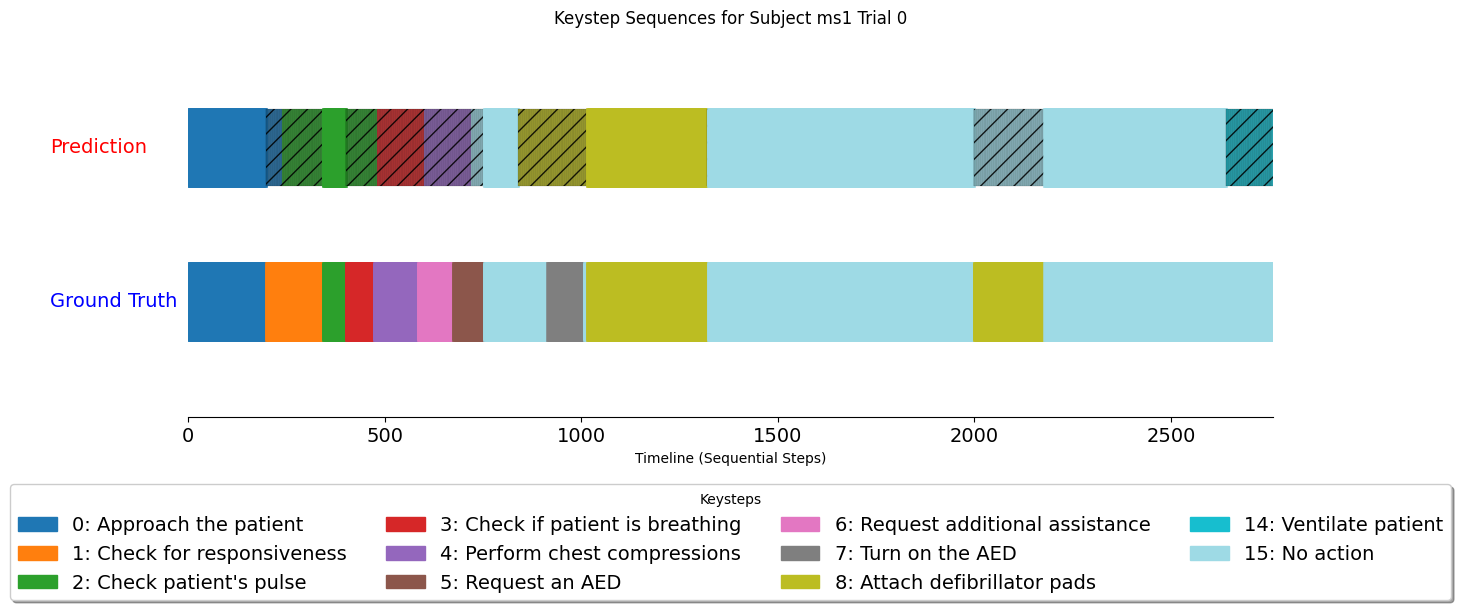

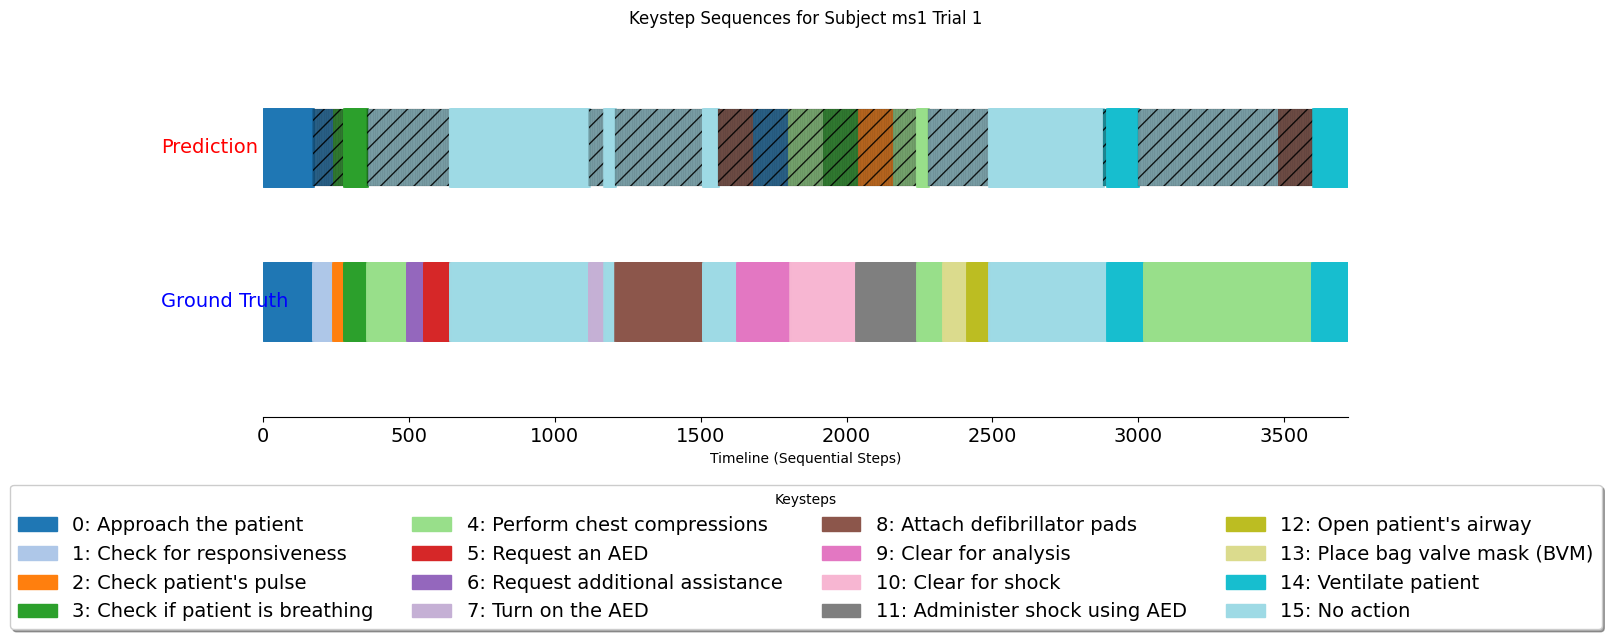

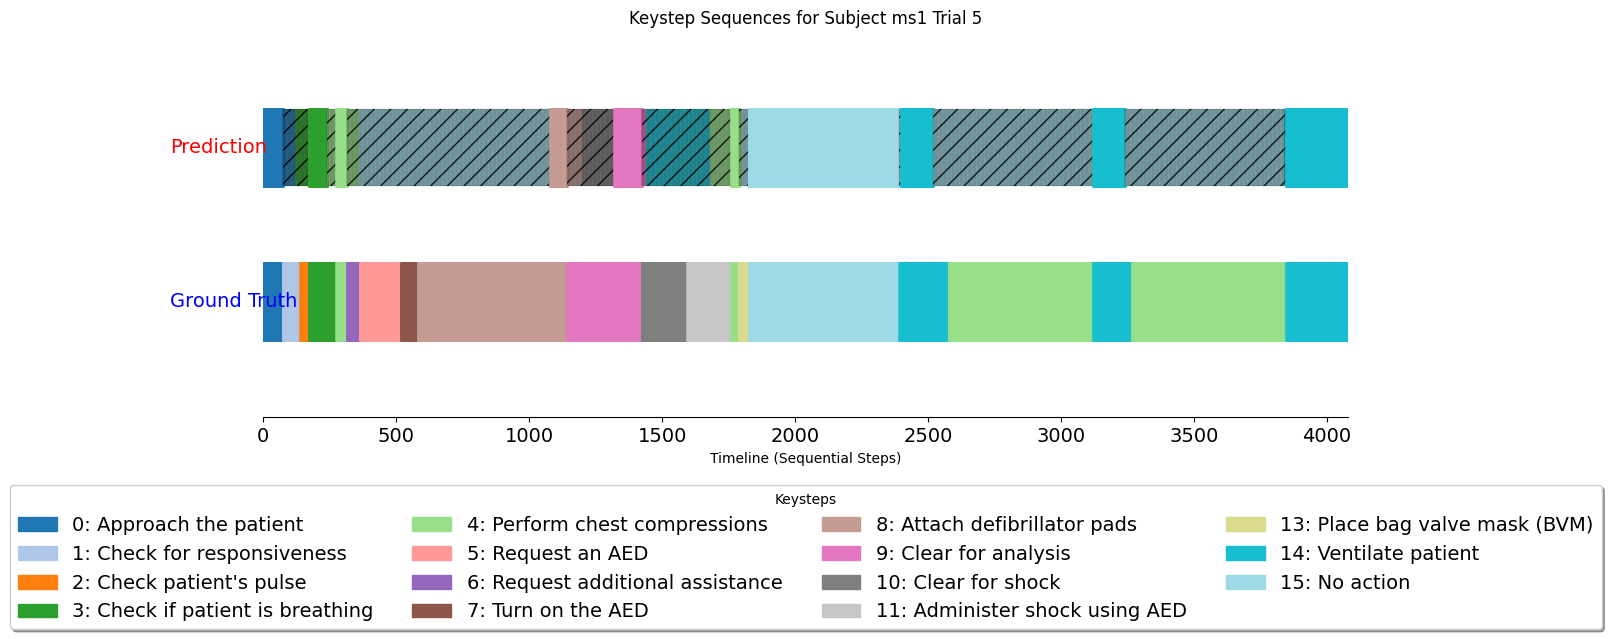

In [ ]:

plots_dir = f'{results_dir}/plots'
os.makedirs(plots_dir, exist_ok=True)

# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]


    #         # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()  # Ground truth per frame
    predicted = group['pred_keystep_id'].tolist()  # Predicted per frame

    def repeat_elements(arr, Y):
        # Use list comprehension to repeat each element Y times
        return [[element] * Y for element in arr]

    Y = len(ground_truth[0])  # For example, repeat each element 3 times
    new_array = repeat_elements(predicted, Y)
    predicted = new_array

    # Flatten ground truth and predicted sublists
    ground_truth = [item for sublist in ground_truth for item in sublist]
    predicted = [item for sublist in predicted for item in sublist]

    print(len(ground_truth))
    print(len(predicted))

    # ground_truth_data['keystep_id'] = ground_truth
    # predicted_data['pred_keystep_id'] = predicted

    ground_truth = {'keystep_id':ground_truth}
    predicted = {'pred_keystep_id': predicted}

    plots_dir = f'{results_dir}/plots/sequence_plots'
    os.makedirs(plots_dir, exist_ok=True)
    # # save figure
    # # Plot using the keystep IDs with unique colors, thicker boundaries, and a horizontal legend
    plot_keystep_sequences(ground_truth, predicted, subject, trial, keysteps_dict, plots_dir)
    # break  # Only plot the first subject's trial for now


### Plot bar stacked timeline

## Detail result plot


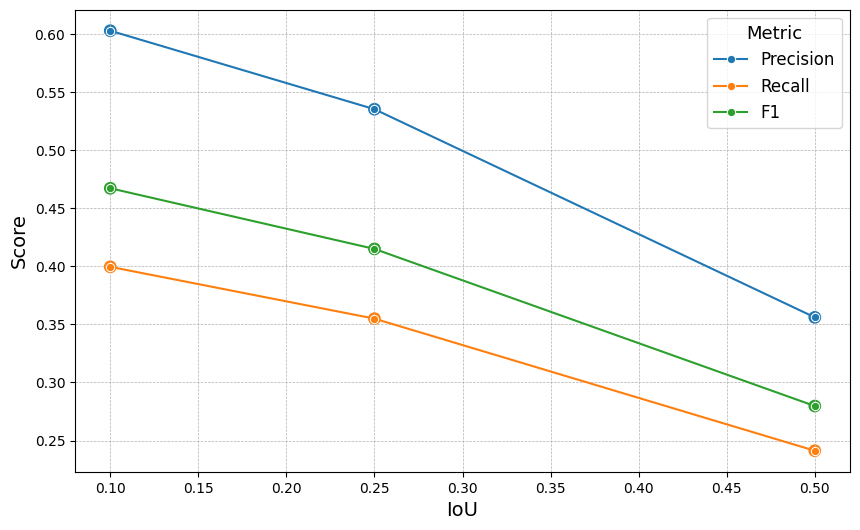

In [13]:
# Load data from CSV
# Replace 'your_results.csv' with the actual path to your CSV file
average_metrics_df = pd.read_csv(f'{results_dir}/average_metrics.csv')

# Prepare data for plotting
plot_data = pd.DataFrame({
    'IoU': [0.1, 0.25, 0.5],
    'Precision': average_metrics_df[['average_precision@0.1', 'average_precision@0.25', 'average_precision@0.5']].values[0],
    'Recall': average_metrics_df[['average_recall@0.1', 'average_recall@0.25', 'average_recall@0.5']].values[0],
    'F1': average_metrics_df[['average_f1@0.1', 'average_f1@0.25', 'average_f1@0.5']].values[0]
}).melt(id_vars='IoU', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='IoU', y='Value', hue='Metric', marker='o')
sns.scatterplot(data=plot_data, x='IoU', y='Value', hue='Metric', s=100, legend=False)  # 's' controls marker size

# Customizing titles and labels for clarity
# plt.title("Comparison of F1, Recall, and Precision Across Different Thresholds")
plt.ylabel("Score", fontsize=14)
plt.xlabel("IoU", fontsize=14)

# Enhancing tick parameters for readability

# Customizing legend
plt.legend(title='Metric', title_fontsize='13', fontsize='12', loc='upper right')

# Adding grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


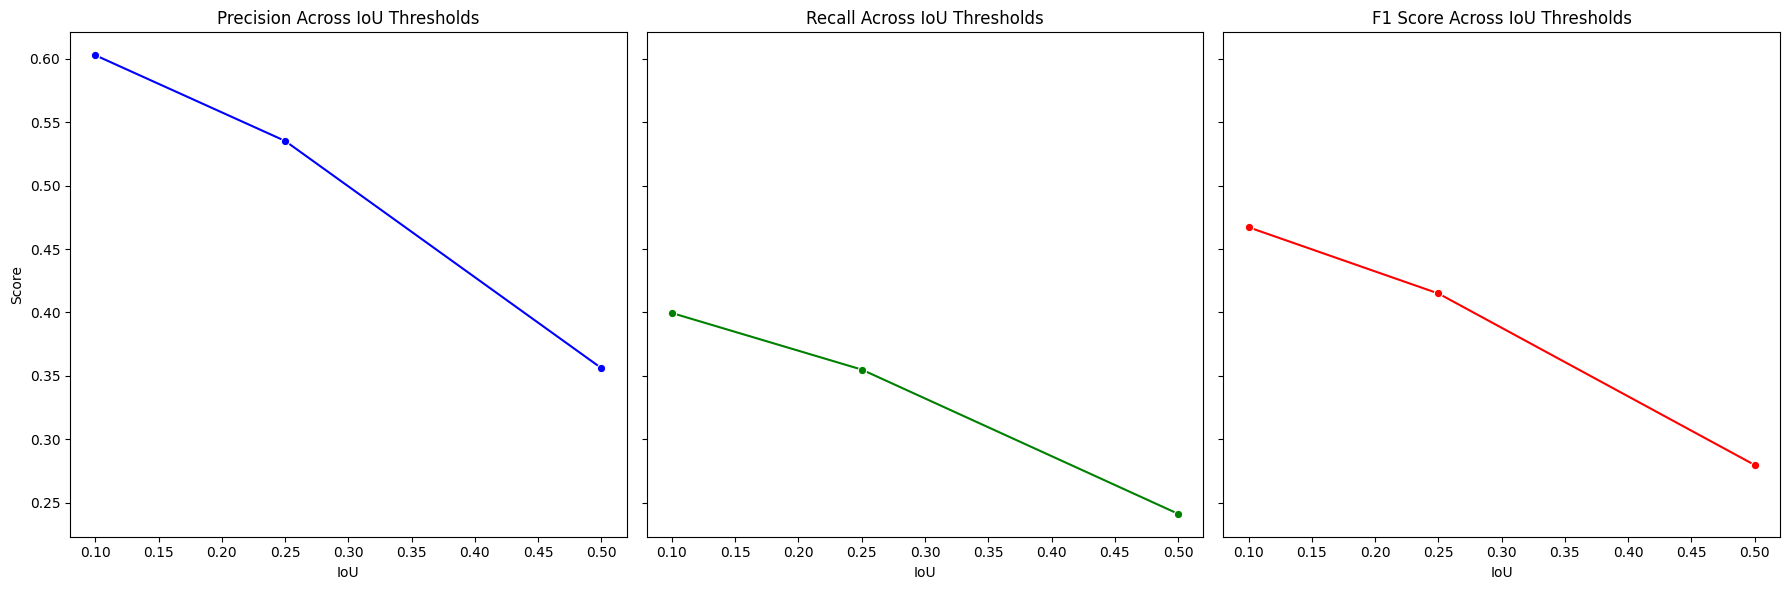

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV
# Replace 'your_results.csv' with the actual path to your CSV file
average_metrics_df = pd.read_csv(f'{results_dir}/average_metrics.csv')

# Prepare data for plotting
plot_data = pd.DataFrame({
    'IoU': [0.1, 0.25, 0.5],
    'Precision': average_metrics_df[['average_precision@0.1', 'average_precision@0.25', 'average_precision@0.5']].values[0],
    'Recall': average_metrics_df[['average_recall@0.1', 'average_recall@0.25', 'average_recall@0.5']].values[0],
    'F1': average_metrics_df[['average_f1@0.1', 'average_f1@0.25', 'average_f1@0.5']].values[0]
}).melt(id_vars='IoU', var_name='Metric', value_name='Value')

# Create subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for Precision
sns.lineplot(data=plot_data[plot_data['Metric'] == 'Precision'], x='IoU', y='Value', marker='o', color='blue', ax=axes[0])
axes[0].set_title("Precision Across IoU Thresholds")
axes[0].set_xlabel("IoU")
axes[0].set_ylabel("Score")

# Plot for Recall
sns.lineplot(data=plot_data[plot_data['Metric'] == 'Recall'], x='IoU', y='Value', marker='o', color='green', ax=axes[1])
axes[1].set_title("Recall Across IoU Thresholds")
axes[1].set_xlabel("IoU")
axes[1].set_ylabel("")

# Plot for F1
sns.lineplot(data=plot_data[plot_data['Metric'] == 'F1'], x='IoU', y='Value', marker='o', color='red', ax=axes[2])
axes[2].set_title("F1 Score Across IoU Thresholds")
axes[2].set_xlabel("IoU")
axes[2].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()
